In [60]:
import xarray as xr

import pandas as pd
import numpy as np
from shapely import geometry
import rioxarray as rio
import geopandas as gpd
import contextily as cx

In [27]:
surface = rio.open_rasterio('data/ghsl_sao_paulo.tiff')
surface

<xarray.DataArray (band: 1, y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

In [55]:
surface.rio.crs

CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [13]:
table = surface.to_series()
table

band  y           x         
1     -2822125.0  -4481875.0   -200.0
                  -4481625.0   -200.0
                  -4481375.0   -200.0
                  -4481125.0   -200.0
                  -4480875.0   -200.0
                                ...  
      -2925875.0  -4366125.0   -200.0
                  -4365875.0   -200.0
                  -4365625.0   -200.0
                  -4365375.0   -200.0
                  -4365125.0   -200.0
Length: 194688, dtype: float32

In [14]:
table = table.reset_index().rename(columns={0: 'values'})
table

,band,y,x,values
0,1,-2822125.0,-4481875.0,-200.0
1,1,-2822125.0,-4481625.0,-200.0
2,1,-2822125.0,-4481375.0,-200.0
3,1,-2822125.0,-4481125.0,-200.0
4,1,-2822125.0,-4480875.0,-200.0
...,...,...,...,...
194683,1,-2925875.0,-4366125.0,-200.0
194684,1,-2925875.0,-4365875.0,-200.0
194685,1,-2925875.0,-4365625.0,-200.0
194686,1,-2925875.0,-4365375.0,-200.0


In [18]:
table.query('values > 2000').info()

<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 5658 to 163524
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    836 non-null    int64  
 1   y       836 non-null    float64
 2   x       836 non-null    float64
 3   values  836 non-null    float32
dtypes: float32(1), float64(2), int64(1)
memory usage: 29.4 KB


In [21]:
def row2cell(row, res_xy):
    ''''
    function to create geometric polgons based on the given resolution
    '''
    res_x, res_y = res_xy
    # xy cordinates are centerd on the pixel
    minX = row['x']-(res_x/2)
    maxX = row['x']+(res_x/2)
    minY = row['y']-(res_y/2)
    maxY = row['y']+(res_y/2)
    poly = geometry.box(
        minX, minY, maxX, maxY
    )
    return poly

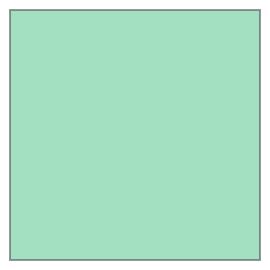

In [34]:
row2cell(table.loc[0, :], (250, 250))

In [22]:
table.loc[0, :]

band            1.0
y        -2822125.0
x        -4481875.0
values       -200.0
Name: 0, dtype: float64

In [56]:
max_polygons = table.query('values > 1000').apply(  # Build polygons for selected cells
    row2cell, res_xy=(250, 250), axis=1
).pipe(gpd.GeoSeries, crs=surface.rio.crs).reset_index(drop=True)
max_polygons

0       POLYGON ((-4471500.000 -2824250.000, -4471500....
1       POLYGON ((-4471750.000 -2824500.000, -4471750....
2       POLYGON ((-4471250.000 -2825250.000, -4471250....
3       POLYGON ((-4471250.000 -2825500.000, -4471250....
4       POLYGON ((-4471000.000 -2825750.000, -4471000....
                              ...                        
7729    POLYGON ((-4430000.000 -2917500.000, -4430000....
7730    POLYGON ((-4429750.000 -2917500.000, -4429750....
7731    POLYGON ((-4430000.000 -2917750.000, -4430000....
7732    POLYGON ((-4433750.000 -2918250.000, -4433750....
7733    POLYGON ((-4436750.000 -2919000.000, -4436750....
Length: 7734, dtype: geometry

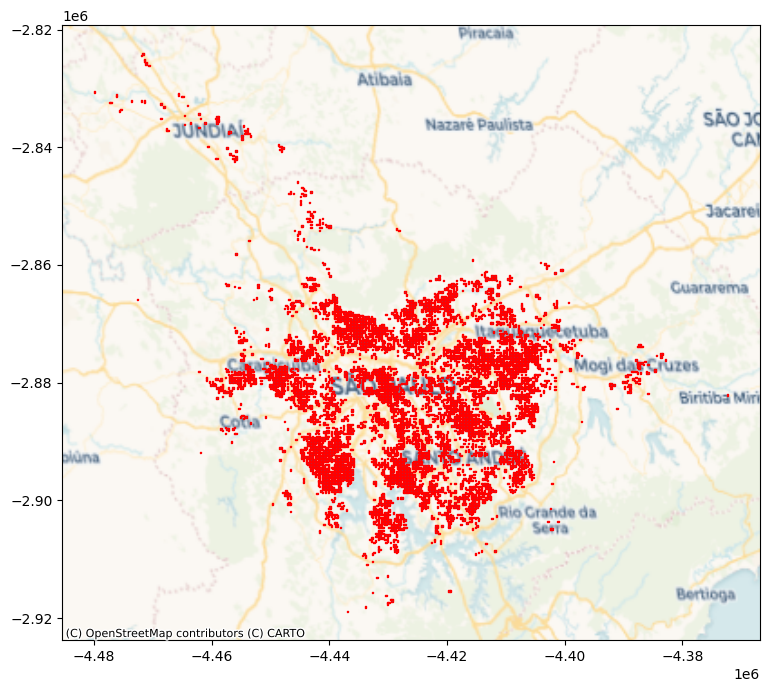

In [63]:
ax = max_polygons.plot(edgecolor="red", figsize=(9, 9))
# Add basemap
cx.add_basemap(
    ax, crs=surface.rio.crs, source=cx.providers.CartoDB.Voyager
)

In [64]:

new_da = xr.DataArray.from_series(
    table.set_index(["band", "y", "x"])["values"]
)
new_da

<xarray.DataArray 'values' (band: 1, y: 416, x: 468)>
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.926e+06 -2.926e+06 ... -2.822e+06 -2.822e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

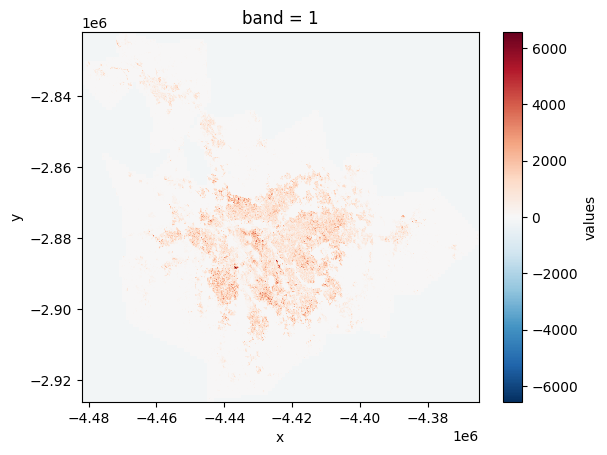

In [65]:
new_da.plot()